**Brief Problem Statement:** Wine Quality Classification using Clustering  

Wine quality is influenced by chemical properties such as acidity, sulfur dioxide levels, and its alcohol content.
So in this Project I used clustering to group wines into quality levels based on their chemical composition using:  
1. K-means 
2. Hierarchical clustering  
  
and compared their performance and the resulting clusters.

# Import Required Libraries

In [ ]:
pip install ucimlrepo

In [5]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import RobustScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score
from ucimlrepo import fetch_ucirepo 
warnings.filterwarnings('ignore')

# Loading and Inspection:


In [6]:
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data as pandas dataframes
X = wine_quality.data.features 
y = wine_quality.data.targets 

Data Source: UCI ML repos  
Link: https://archive.ics.uci.edu/dataset/186/wine+quality  
no. of features: 11  
Feature types: All numeric (contineous) refers to different element concentrations in the wine.  
no. of instances:  6497

Input variables (based on physicochemical tests) and their summary statistics:


In [7]:
# data description
print(X.describe())

       fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

In [ ]:
# firsty few columns of the data
X.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  
0      9.4  
1      9.8  
2      9.8  
3      9.8  
4      9.4

# Exploratory Data Analysis (EDA)


Checking for missing values:

In [ ]:
# checking for missing values
missing_values = X.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64


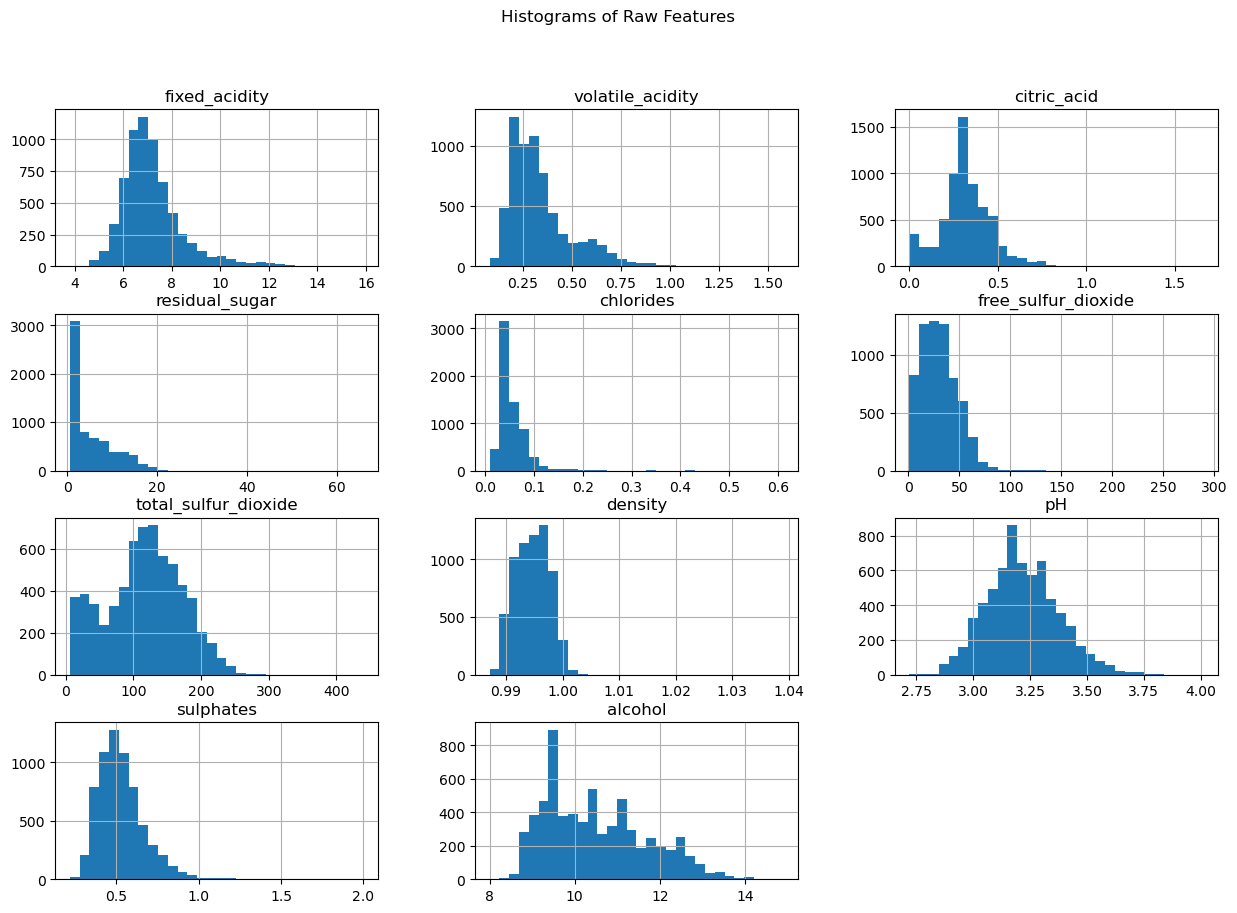

In [7]:
# Plot histograms for each feature to understand their distributions
X.hist(bins=30, figsize=(15, 10))
plt.suptitle('Histograms of Raw Features')
plt.show()

checking for outliers (Box Plot):

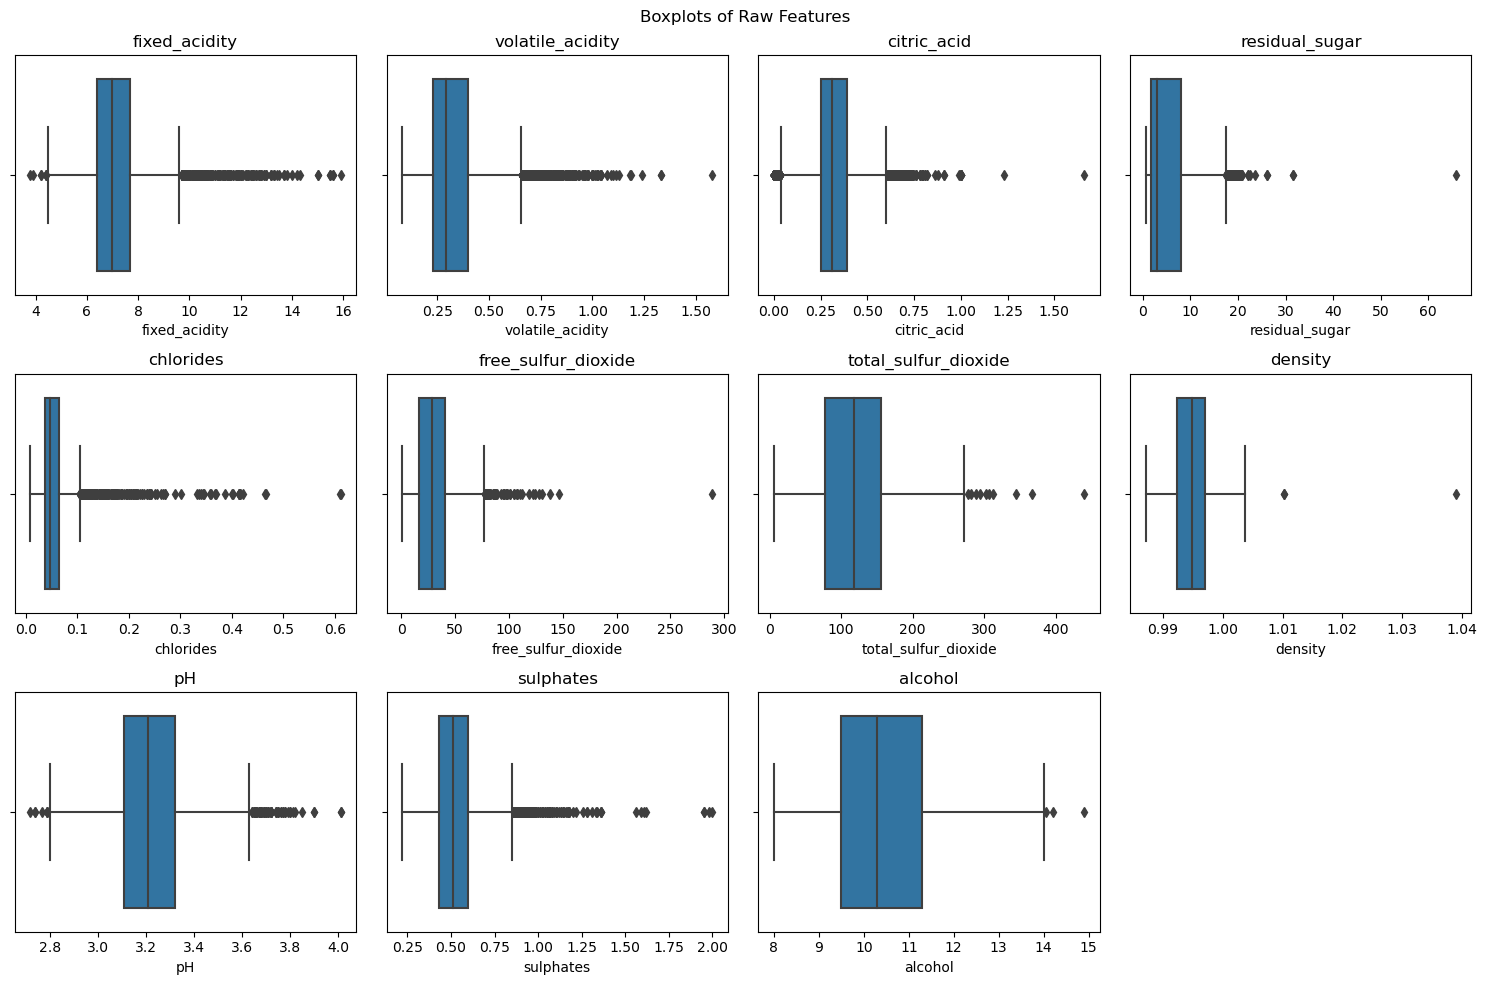

In [ ]:
# Boxplots of the raw features
plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x=X[col])
    plt.title(col)
plt.suptitle('Boxplots of Raw Features')
plt.tight_layout()
plt.show()

In [9]:
# Calculate the IQR for each feature
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

# Determine outliers for each feature
outliers = ((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).sum()

# Print the number of outliers for each feature
print("Number of outliers for each feature:\n", outliers)

Number of outliers for each feature:
 fixed_acidity           357
volatile_acidity        377
citric_acid             509
residual_sugar          118
chlorides               286
free_sulfur_dioxide      62
total_sulfur_dioxide     10
density                   3
pH                       73
sulphates               191
alcohol                   3
dtype: int64


After examining the outliers:  
There Happen to be alot of outliers but most of them lie within normal ranges so they are not errors.  
I was suspecious about the density outliers but turns out in fact some wines can have such high densities depending on their sugar content and minirals.  
so instead of removing a large p[ortion of the data I will elect to use a robust scaling method.

HeatMap of correlations:

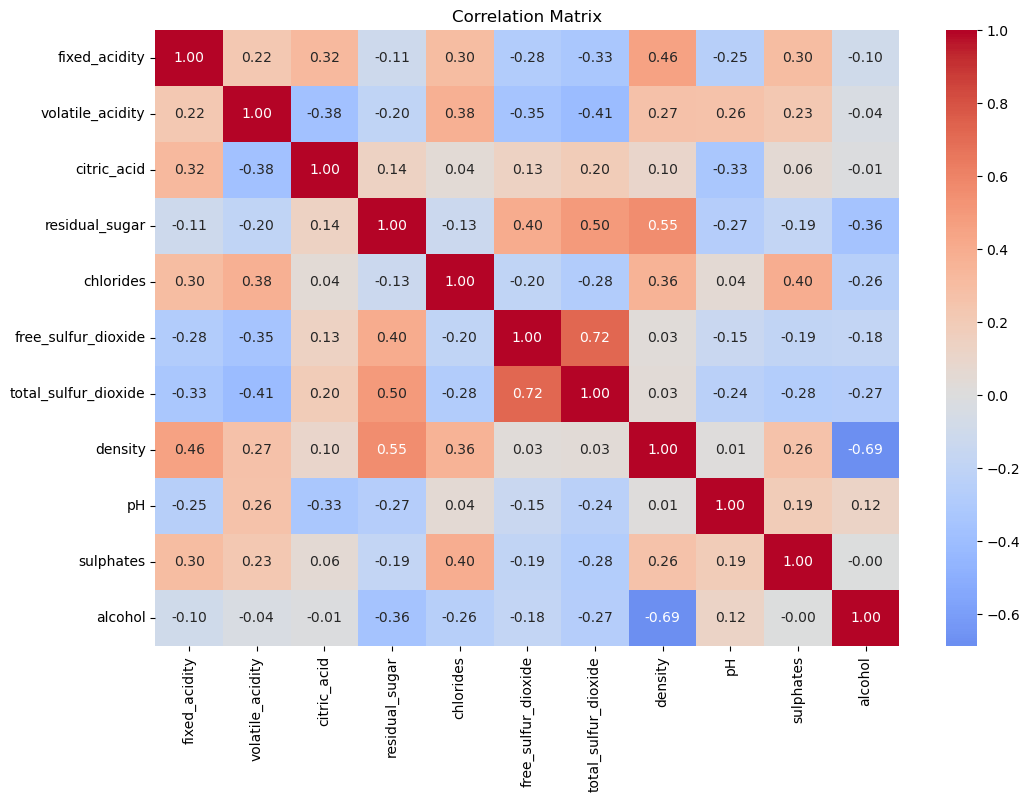

In [10]:
plt.figure(figsize=(12, 8))
correlation_matrix = X.corr()
sns.heatmap(correlation_matrix,center=0,cmap='coolwarm',  annot=True, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### feature engineering:

In this code, we perform the following steps to visualize the correlation matrix of the dataset:


**New Feature**: calculated  `bound_sulfur_dioxide` by subtracting `free_sulfur_dioxide` from `total_sulfur_dioxide`.
since total sulfur oxide is highly corelated with its free form but the free and bound  
forms have different effects on the quality so i elected to remove the total and keep the 2 values. 


**Drop Density**: droped the `density` column from the DataFrame as the density is highly cvorelated with alot of feature and knowing all  
the concentrations of different elements , salts alcohol sugar, etc you can calculate the density which explains its high corellation with alot of features.



In [11]:
x_new = X.copy()
x_new['bound_sulfur_dioxide'] = x_new['total_sulfur_dioxide'] - x_new['free_sulfur_dioxide']
x_new.drop(['total_sulfur_dioxide', 'density'], axis=1, inplace=True)

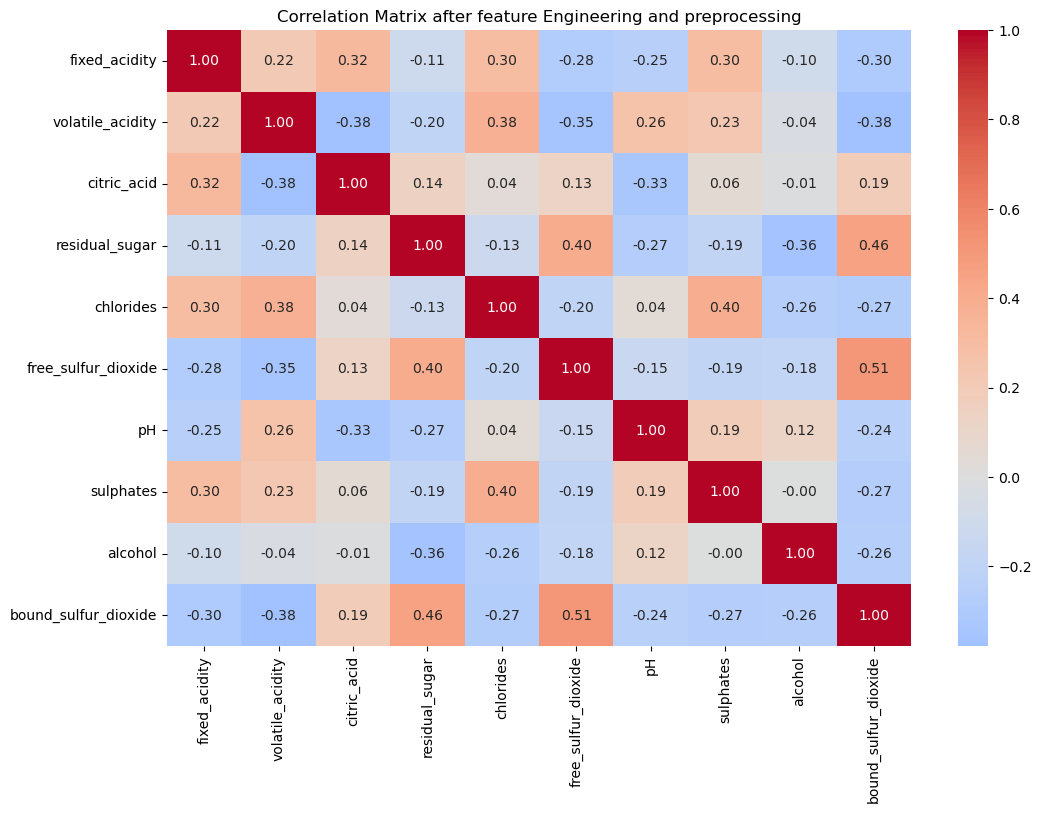

In [12]:
plt.figure(figsize=(12, 8))
correlation_matrix = x_new.corr()
sns.heatmap(correlation_matrix,center=0,cmap='coolwarm',  annot=True, fmt='.2f')
plt.title('Correlation Matrix after feature Engineering and preprocessing')
plt.show()

We can already see the effect of the last 2 steps on the correlation heat map

**To scale or not to scale?**

Scaling is the obvious choice here since clustering algorithms such as K-means are distance based algorithms, so features with larger scales can influence the results much more and the data we have is varying in scale 

Clustering algorithms such as K-Means and Hierarchial clustering are sensitive to outliers and their results are affected negatively by highly corelated features.  
So I elected to scale the data with RobustScaler() since it will take care of both issues:

In [13]:
scaler = RobustScaler()
scaled_data = scaler.fit_transform(x_new)

# Convert the scaled data to DataFrame
scaled_X = pd.DataFrame(scaled_data, columns=x_new.columns)

# K-Means Clustering


# Determine Optimal Number of Clusters
Use methods such as the Elbow method and Silhouette score to determine the optimal number of clusters for K-Means.

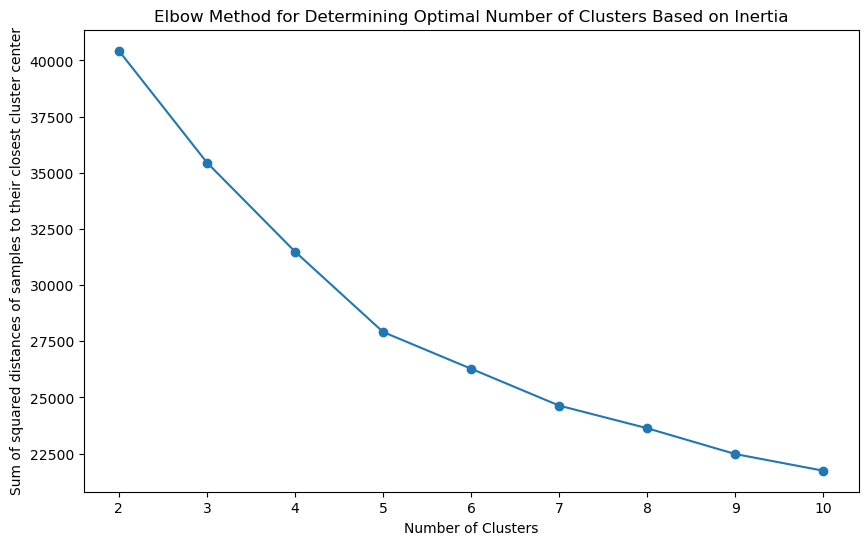

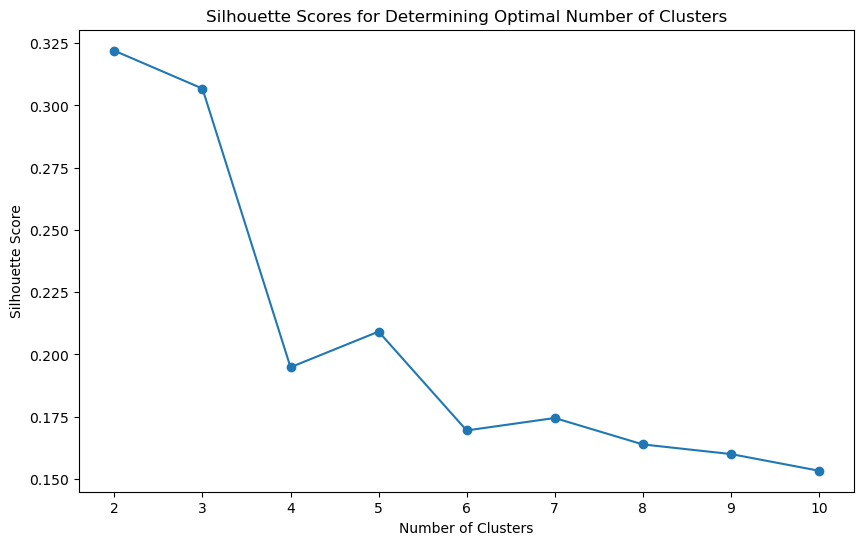

In [ ]:
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_X)
    inertia.append(kmeans.inertia_)

# Plot the inertia for each k to find the elbow point
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distances of samples to their closest cluster center')
plt.title('Elbow Method for Determining Optimal Number of Clusters Based on Inertia')
plt.show()

# Silhouette Scores for each k
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_X)
    score = silhouette_score(scaled_X, kmeans.labels_)
    silhouette_scores.append(score)

# Plot the Silhouette Scores for each k
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Determining Optimal Number of Clusters')
plt.show()

# Apply K-Means Clustering
Apply K-Means clustering to the dataset using the optimal number of clusters.

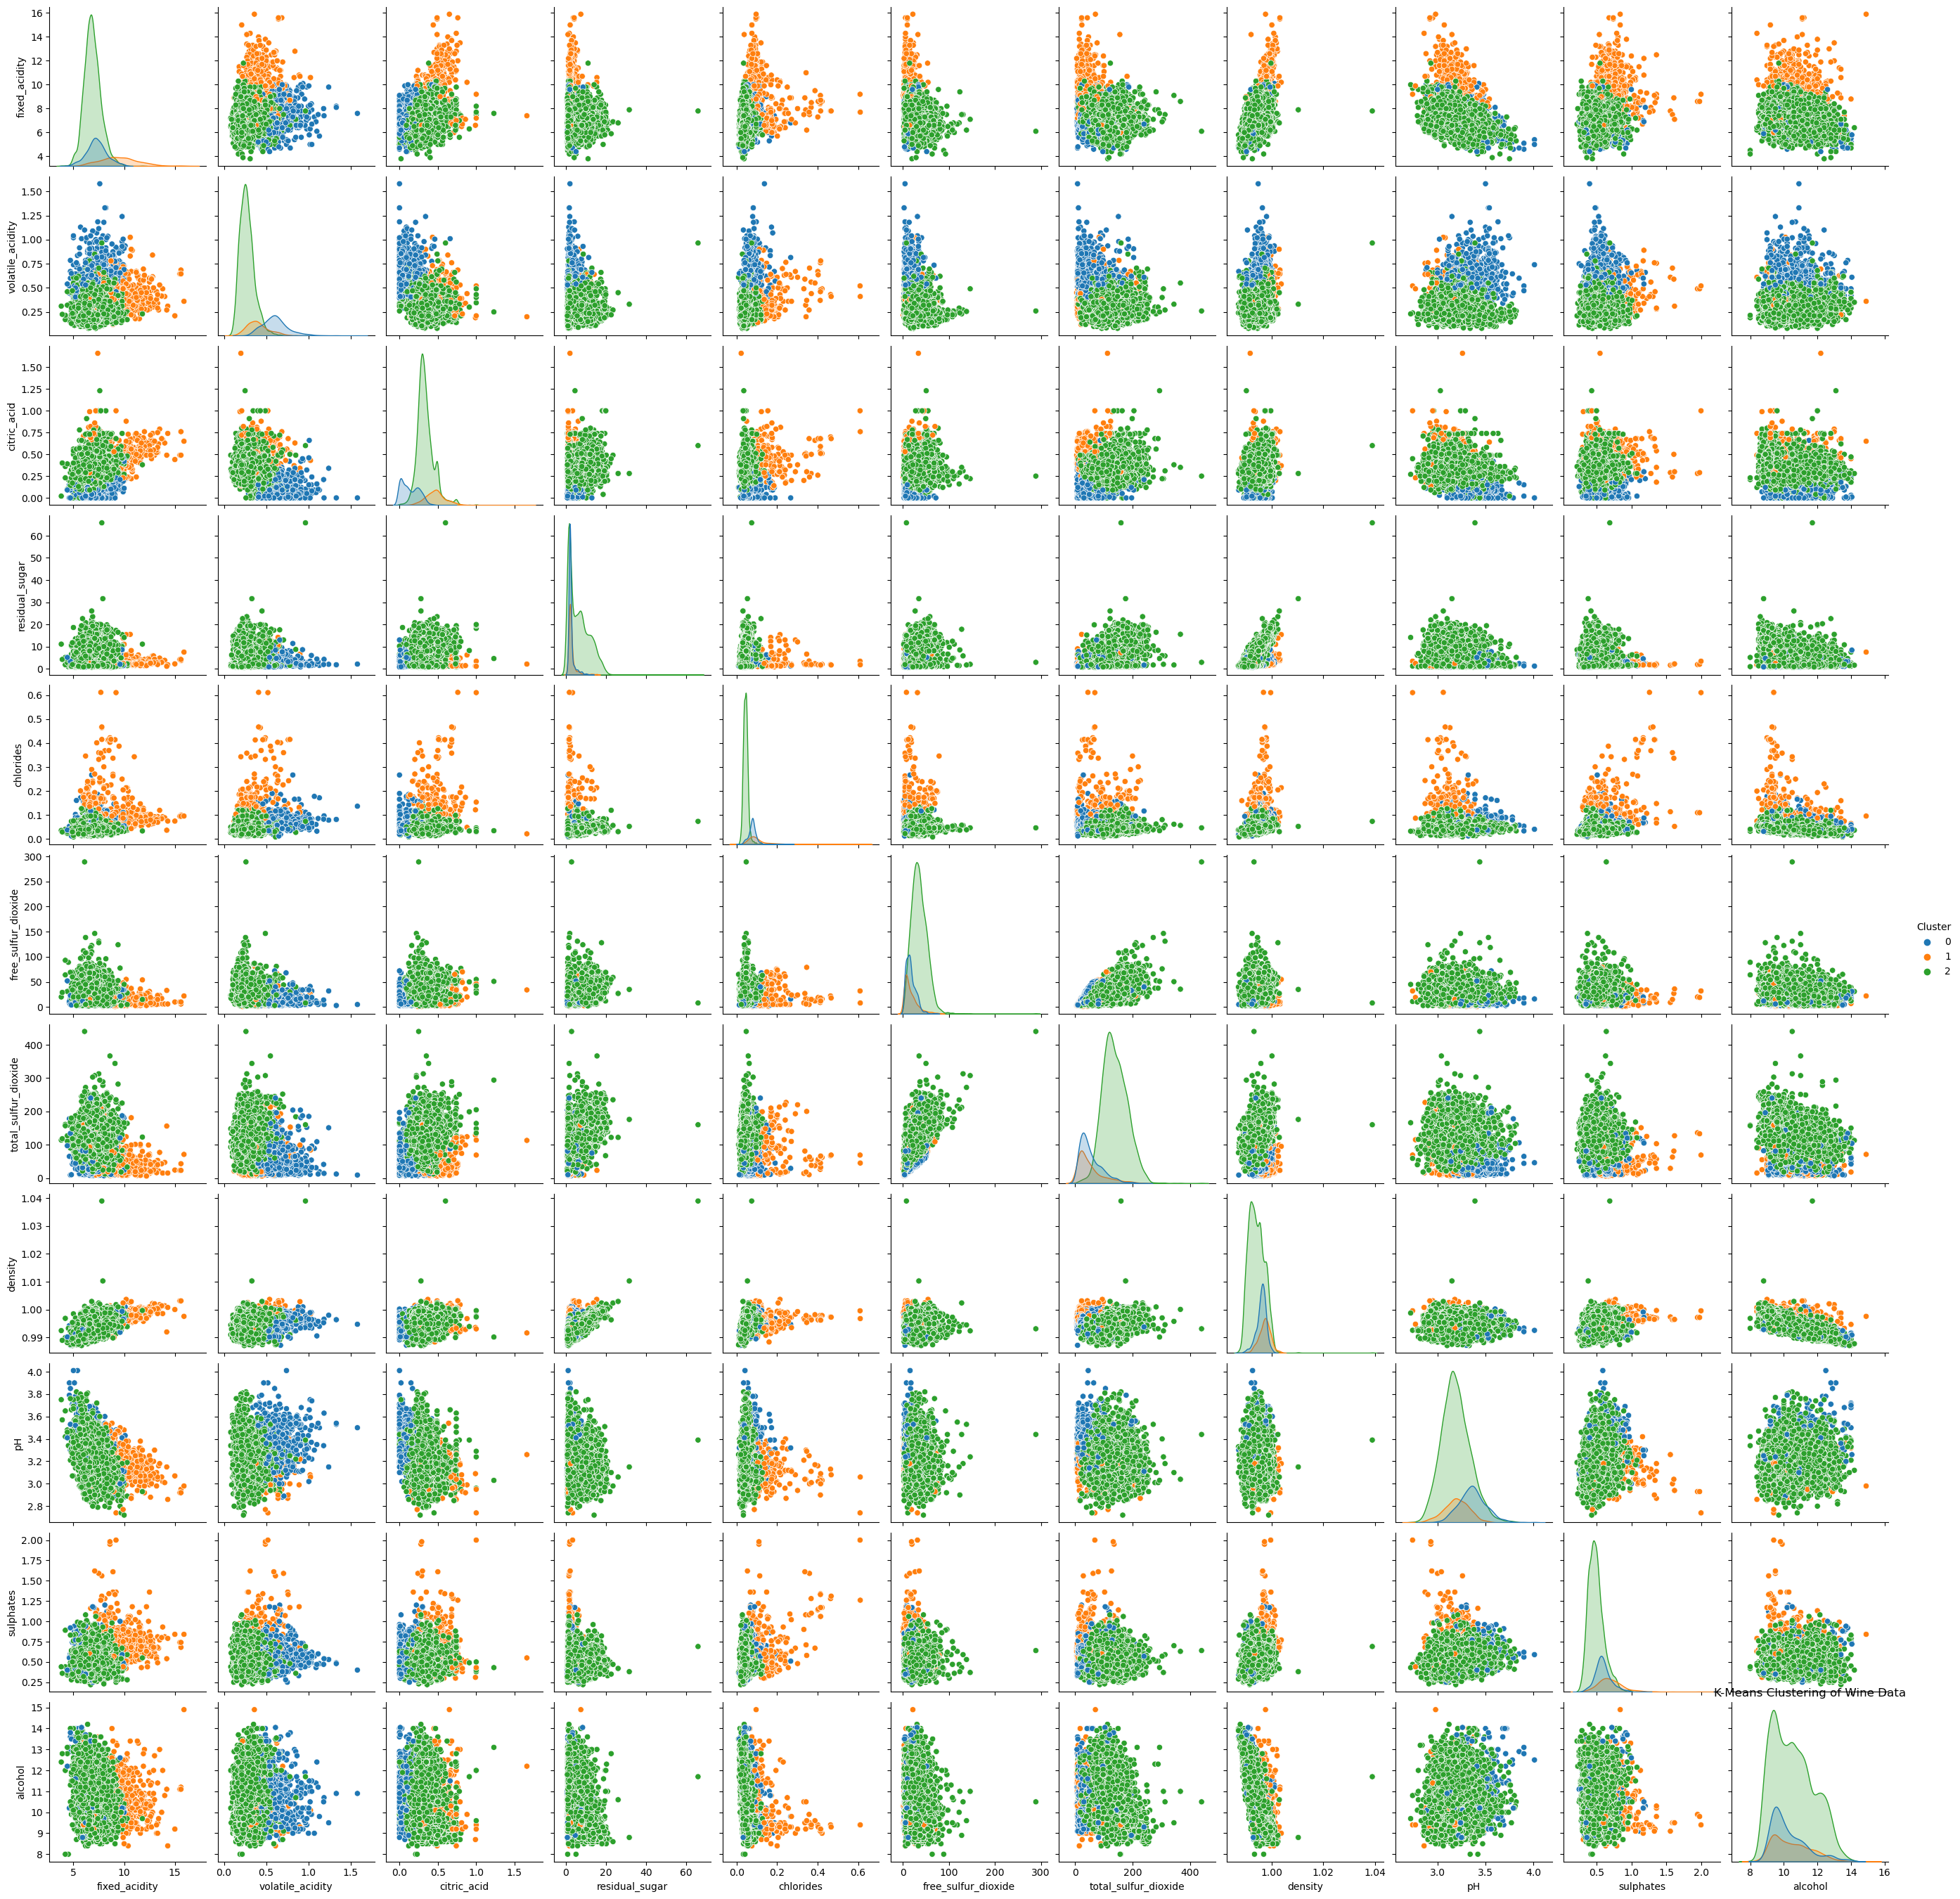

Silhouette Score for k=3: 0.31


In [ ]:
# From the Elbow plot and Silhouette Scores, I choose k=3
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(scaled_X)
clusters = kmeans.labels_

# Add cluster labels to dataset
X['Cluster'] = clusters

# Visualizing the clusters using a pairplot
sns.pairplot(X, hue='Cluster', palette='tab10')
plt.title('K-Means Clustering of Wine Data')
plt.show()

# Calculating silhouette score 
silhouette_avg = silhouette_score(scaled_X, clusters)
print(f'Silhouette Score for k={optimal_k}: {silhouette_avg:.2f}')

# Hierarchical Clustering


### Determine Optimal distance metrics and linkage methods

I will choose Eucledian distance here since it works best for scaled data and ward linkage since it forms more compact clusters

# Applying Hierarchical Clustering

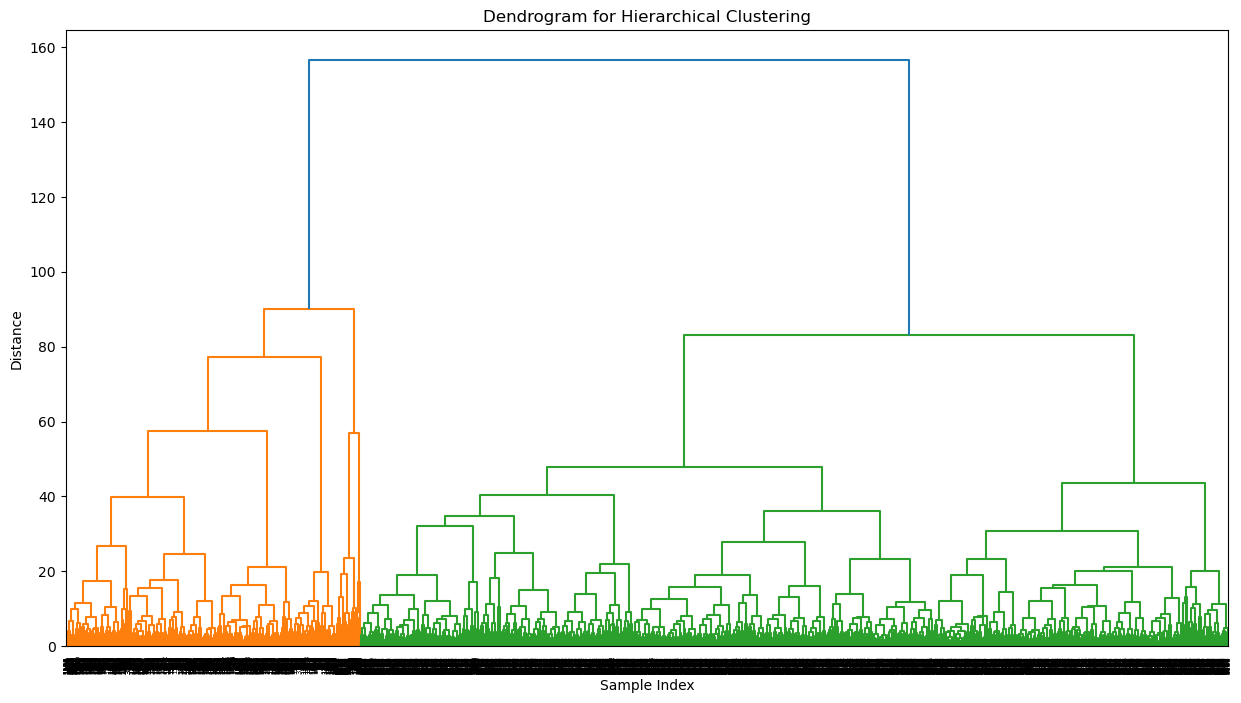

In [ ]:
linked = linkage(scaled_X, method='ward', metric='euclidean')

# Plot dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linked, orientation='top', distance_sort='descending')
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [ ]:
num_clusters = 3 #SAME AS K MEANS
hierarchical_clusters = fcluster(linked, num_clusters, criterion='maxclust')

# Calculate  silhouette score for hierarchical clustering
silhouette_avg_hierarchical = silhouette_score(scaled_X, hierarchical_clusters)
print(f'Silhouette Score for Hierarchical Clustering with {num_clusters} clusters: {silhouette_avg_hierarchical:.2f}')

Silhouette Score for Hierarchical Clustering with 3 clusters: 0.31


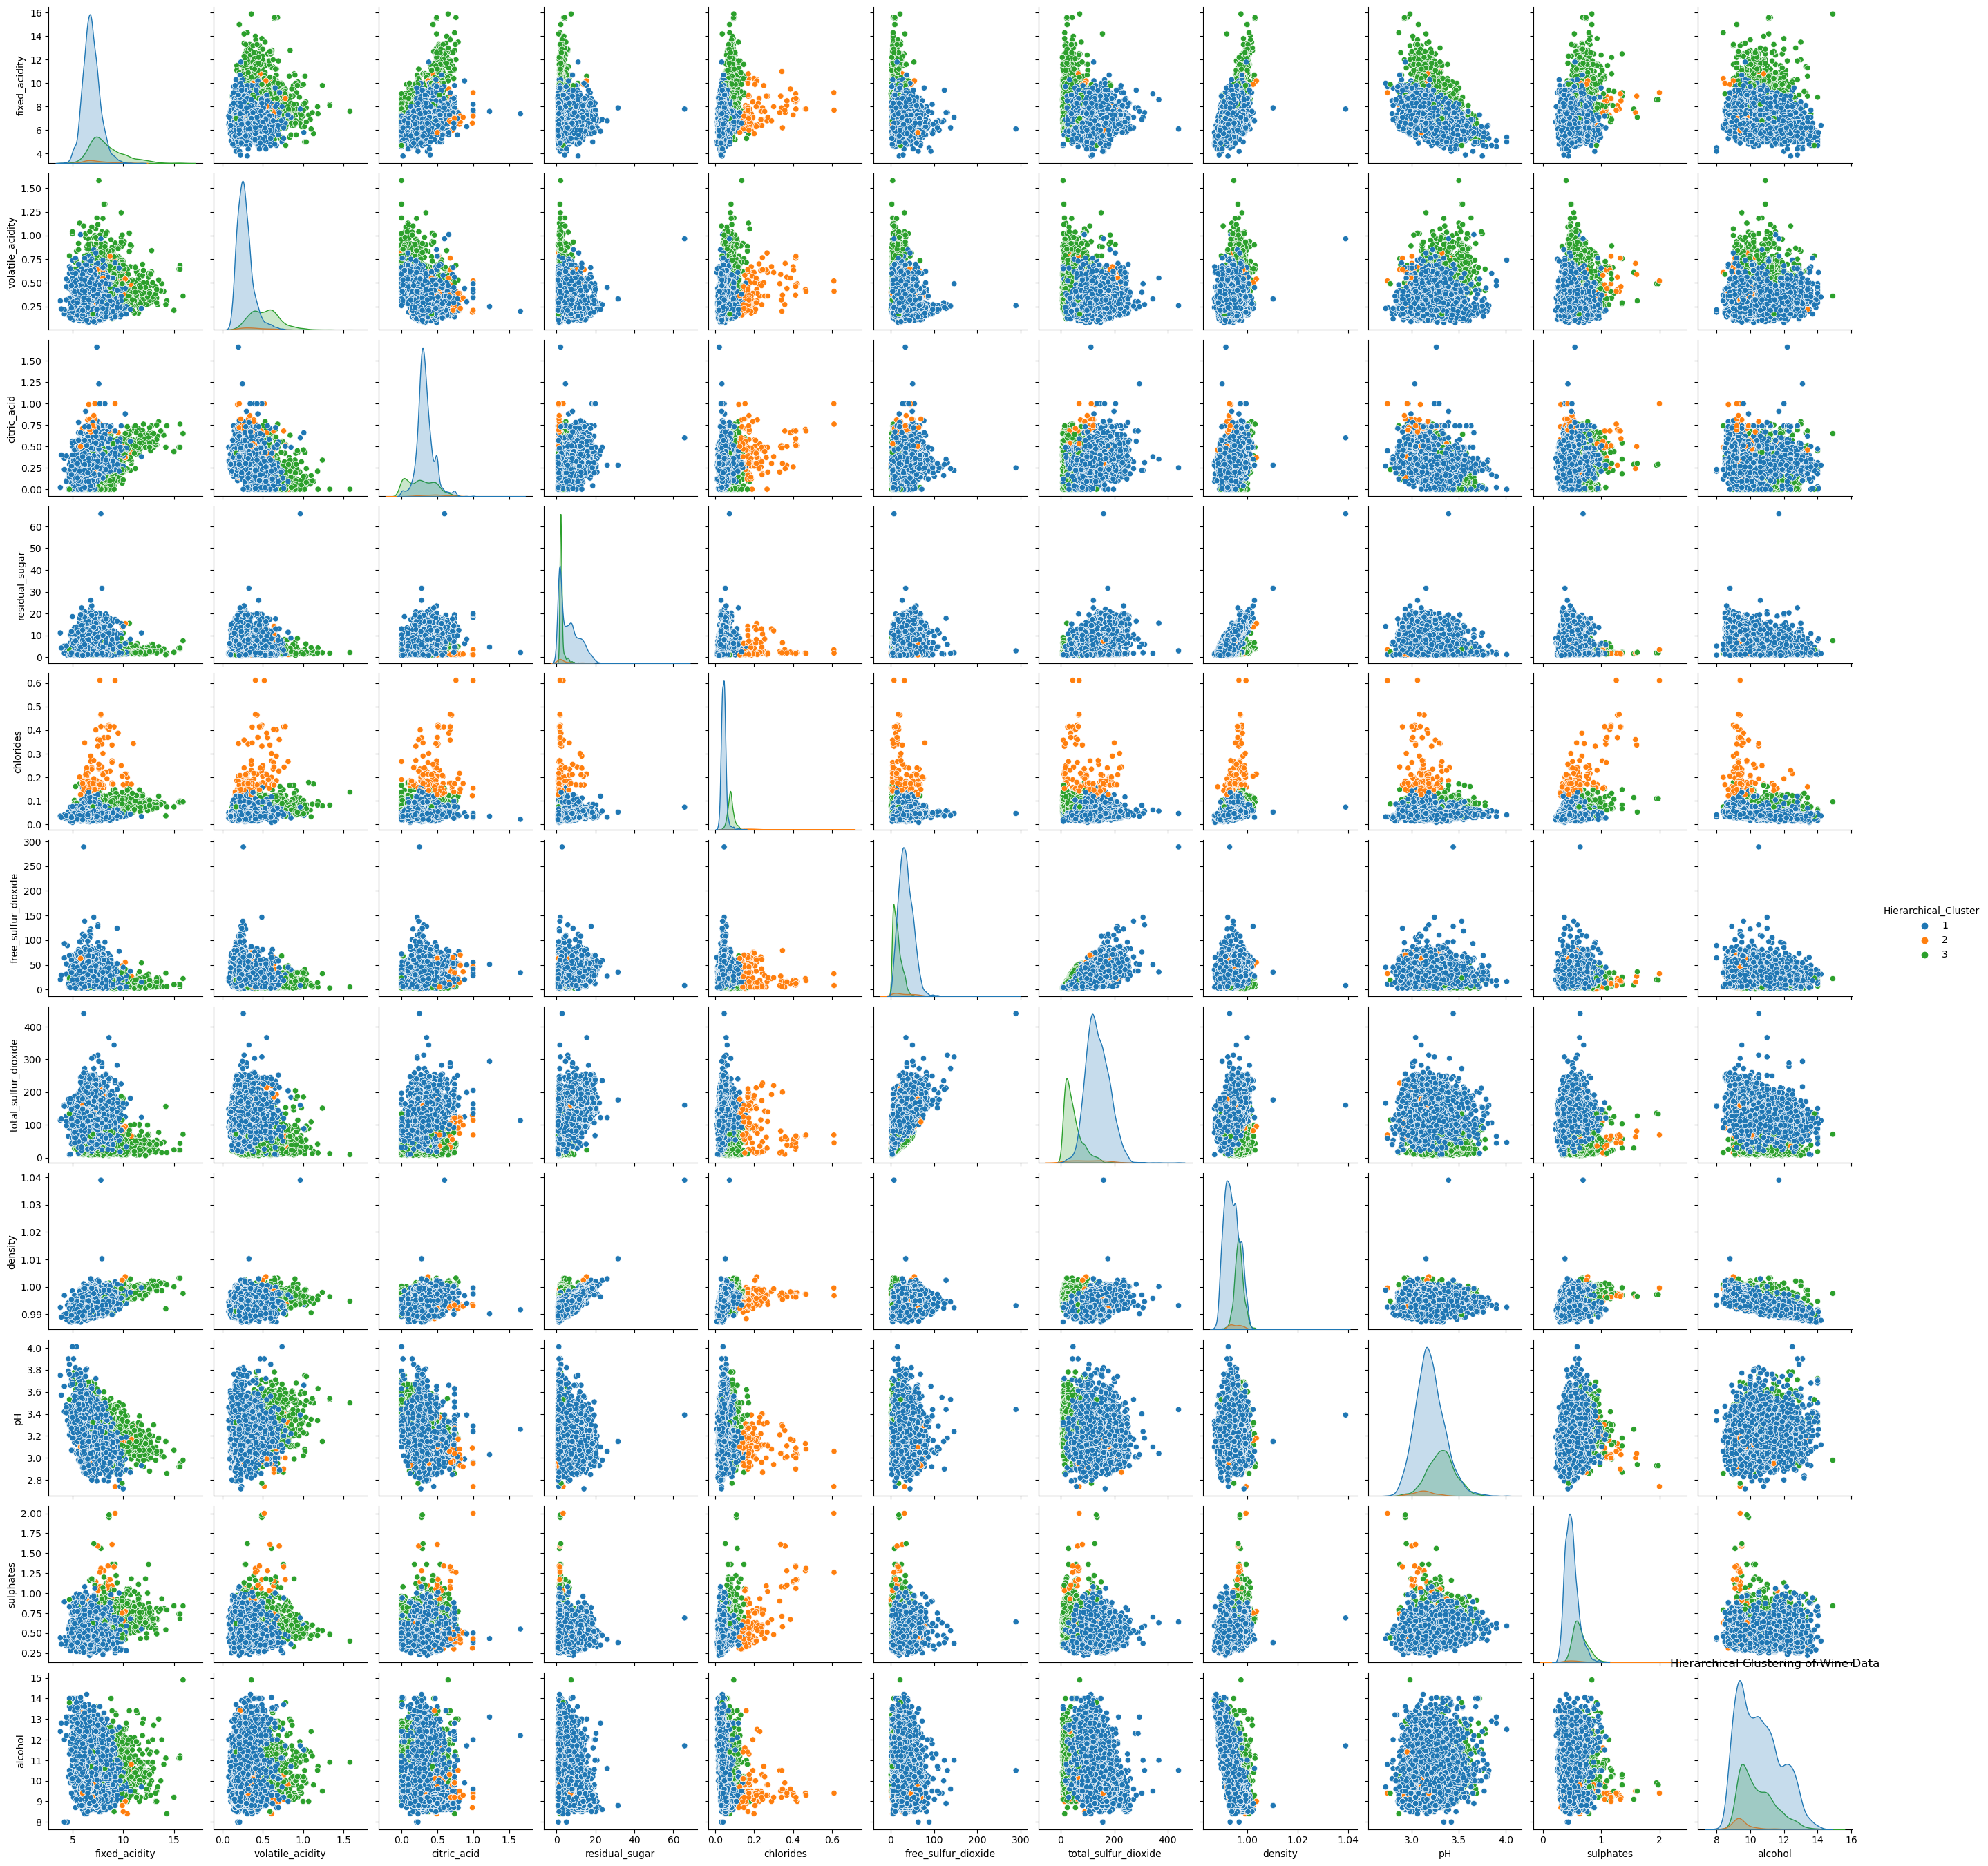

Silhouette Score for Hierarchical Clustering with 3 clusters: 0.31


In [ ]:
# Visualize the hierarchical clusters using a pairplot
X['Hierarchical_Cluster'] = hierarchical_clusters
X_plot = X.copy()
X_plot.drop('Cluster', axis=1, inplace=True)
sns.pairplot(X_plot, hue='Hierarchical_Cluster', palette='tab10')
plt.show()

# Comparison of Clustering Results

In [19]:
# Compare the silhouette scores 
print(f'Silhouette Score for K-Means Clustering with {num_clusters} clusters: {silhouette_avg:.2f}')
print(f'Silhouette Score for Hierarchical Clustering with {num_clusters} clusters: {silhouette_avg_hierarchical:.2f}')

Silhouette Score for K-Means Clustering with 3 clusters: 0.31
Silhouette Score for Hierarchical Clustering with 3 clusters: 0.31


And visually inspecting the resulting pairplots of clusters we can see their grouping is quite simillar

# Discussion and Conclusion

**Findings:**

Both K-Means and Hierarchical Clustering were applied to the Wine dataset.  
The optimal number of clusters was determined to be 3 by using both methods using the Elbow Method and Silhouette Scores to get a score with lower error and good cohesion  
The Silhouette Score for K-Means Clustering with 3 clusters was 0.31  
The Silhouette Score for Hierarchical Clustering with 3 clusters was 0.31  
Comparing the distribution among the features and their scores they appear simillar in performance  

**Limitations:**

Both K-Means and Hierarchical Clustering were applied to the Wine dataset.  
K-Means clustering assumeing spherical clusters which may not perform well if the clusters have different shapes  
Hierarchical Clustering can be computationally expensive for larger datasets    

**Potential Improvements:**

Experimenting with different clustering methods.  
Perform feature selection or dimensionality reduction like PCA before clustering.    
Explore different scaling methods like MinMaxScaler and see how they impact results      

# GitHub Repo Link:

https://github.com/alimonds790/wine_quality_clustering/

# References:

1. KMEANS. (n.d.). Scikit-learn. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html  
2. Gültekin, H. (2023, September 7). What is Silhouette Score? - Hazal Gültekin - Medium. Medium. https://medium.com/@hazallgultekin/what-is-silhouette-score-f428fb39bf9a